# Merge all PVI datasets

Unfortunatley, data from 2002 on PVI is unavailable, so Data is limited to 2004-2021

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#awaiting Cook release of 2002 datapoints
#df108 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_108.csv")

In [3]:
df109 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_109.csv")

In [4]:
df110 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_110.csv")

In [5]:
df111 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_111.csv")

In [6]:
df112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_112.csv")

In [7]:
df113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_113.csv")

In [8]:
df114 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_114.csv")

In [9]:
df115 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_115.csv")

In [10]:
df116 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_116.csv")

In [11]:
df117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_117.csv")

In [12]:
df = pd.concat([df109,df110,df111,df112,df113,df114,df115,df116,df117])

In [13]:
df["PVI"] = df["PVI"].str.replace("D+0","R+0")

## Analyze the Aggregated Data

In [14]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth, coord_flip, scale_color_manual
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [15]:
#group by metric and average GOP seats
bm = df.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm = bm.sort_values('metric')
bm = bm.reset_index()

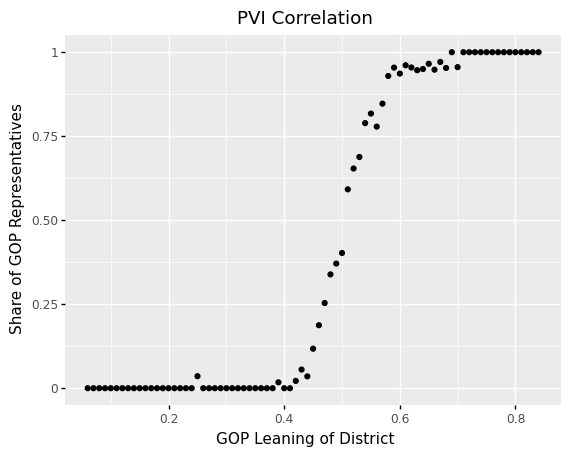

<ggplot: (8771372152811)>

In [16]:
#Plot averages
(p9.ggplot(data=bm, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

- 0 to .24 is solely Democratic
- .25 to .42 is less than 5% Republican
- .43 and .44 is less than 10% Republican
- .45 to .54 deserve their own bins
- .55 and .57 are more than 75% Republican
- .58 to .7 are more than 90% Republican
- .71 to 1 is solely Republican

Beacuse of the variation with the aggregated dataset, we will bin the tails to remove noise

In [17]:
binned = df
binned["bin"] = pd.cut(binned['metric'], 
    [0, .24, .42, .44, .45, .46, .47, .48, .49, .5,
    .51, .52, .53, .54, .57, .7, 1])
binned.bin = binned.bin.astype(str)
binned = binned.sort_values(by="metric")

In [18]:
bin_dict = {
'(0.0, 0.24]' : 'D+26+',
'(0.24, 0.42]' : 'D+25 to D+8',
'(0.42, 0.44]' : 'D+7 to D+6',
'(0.44, 0.45]' : 'D+5',
'(0.45, 0.46]' : 'D+4',
'(0.46, 0.47]' : 'D+3',
'(0.47, 0.48]' : 'D+2',
'(0.48, 0.49]' : 'D+1',
'(0.49, 0.5]' : 'EVEN',
'(0.5, 0.51]' : 'R+1',
'(0.51, 0.52]' : 'R+2',
'(0.52, 0.53]' : 'R+3',
'(0.53, 0.54]' : 'R+4',
'(0.54, 0.57]' : 'R+5 to R+7',
'(0.57, 0.7]' : 'R+8 to R+20',
'(0.7, 1.0]' : 'R+21+',
}

In [19]:
df = binned.replace({"bin":bin_dict})
df.head()

,year,congress,ST,ST#,seat,is_GOP,PVI,metric,bin
271,2018,116,NY,NY15,D,0,D+44,0.06,D+26+
271,2016,115,NY,NY15,D,0,D+44,0.06,D+26+
274,2004,109,NY,NY16,D,0,D+43,0.07,D+26+
269,2018,116,NY,NY13,D,0,D+43,0.07,D+26+
271,2014,114,NY,NY15,D,0,D+43,0.07,D+26+


In [20]:
#create a column indicating if it was a wave year or not
df_red = pd.concat([df[df["year"] == 2010], df[df["year"] == 2014]])
df_blue = pd.concat([df[df["year"] == 2006], df[df["year"] == 2008], df[df["year"] == 2018]])
df_neutral = pd.concat([df[df["year"] == 2004], df[df["year"] == 2012], df[df["year"] == 2016], df[df["year"] == 2020]])
df_all = df
print(df_red.shape, df_blue.shape, df_neutral.shape)

(870, 9) (1305, 9) (1740, 9)


In [21]:
def agg_probs(df):
    sort = df.groupby("bin").mean()
    sort = sort.sort_values(by="metric")
    return pd.DataFrame(sort.is_GOP)

In [22]:
#create a wide version for visual analysis
all_probs = agg_probs(df).rename(columns={"is_GOP":"prob_GOP_all"})
neutral_probs = agg_probs(df_neutral).rename(columns={"is_GOP":"prob_GOP_neutral"})
red_probs = agg_probs(df_red).rename(columns={"is_GOP":"prob_GOP_red"})
blue_probs = agg_probs(df_blue).rename(columns={"is_GOP":"prob_GOP_blue"})
all_neutral = all_probs.join(neutral_probs)
all_neutral_red = all_neutral.join(red_probs)
wave_probs_wide = all_neutral_red.join(blue_probs).reset_index()
wave_probs_wide

,bin,prob_GOP_all,prob_GOP_neutral,prob_GOP_red,prob_GOP_blue
0,D+26+,0.000000,0.000000,0.000000,0.000000
1,D+25 to D+8,0.004449,0.002463,0.005076,0.006757
2,D+7 to D+6,0.044586,0.042857,0.034483,0.051724
3,D+5,0.117647,0.171429,0.120000,0.040000
4,D+4,0.187500,0.214286,0.176471,0.157895
5,D+3,0.253521,0.250000,0.411765,0.153846
6,D+2,0.338710,0.400000,0.416667,0.240000
7,D+1,0.370968,0.370370,0.615385,0.227273
8,EVEN,0.402439,0.371429,0.666667,0.275862
9,R+1,0.591837,0.674419,0.681818,0.424242


In [23]:
#create a long version for easy split graphing
all_probs = agg_probs(df)
neutral_probs = agg_probs(df_neutral)
red_probs = agg_probs(df_red)
blue_probs = agg_probs(df_blue)
all_probs["wave"] = "All Years"
neutral_probs["wave"] = "neutral"
red_probs["wave"] = "Red Wave Average (2010, 2014)"
blue_probs["wave"] = "Blue Wave Average (2006, 2008, 2018)"
#wave_probs_long = pd.concat([all_probs,neutral_probs,red_probs,blue_probs]).reset_index()
wave_probs_long = pd.concat([all_probs,red_probs,blue_probs]).reset_index()
wave_probs_long["bin"] = pd.Categorical(wave_probs_long["bin"], ["D+26+","D+25 to D+8","D+7 to D+6","D+5","D+4","D+3","D+2","D+1",
                                          "EVEN","R+1","R+2","R+3","R+4","R+5 to R+7","R+8 to R+20","R+21+"])

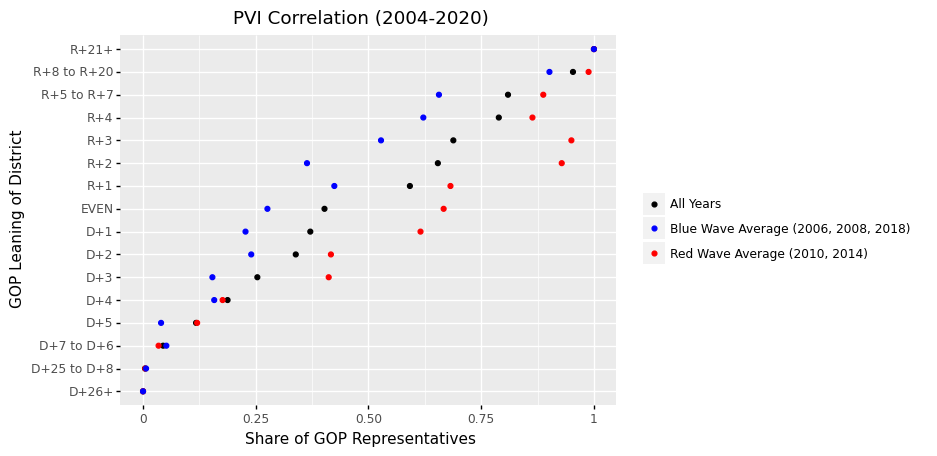

<ggplot: (8771372666109)>

In [24]:
#Plot averages
(p9.ggplot(data=wave_probs_long, mapping=p9.aes(x='bin', y='is_GOP'))
 + p9.geom_point(aes(color=wave_probs_long.wave)) 
 + scale_color_manual(values=("black", "blue", "red"))
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation (2004-2020)")) + coord_flip()

## Output a Dictionaries

This chunk below needs some work to conduct aggregations for a possible red or blue wave

In [25]:
#create a function to ouput dictionaries
#stylize this to include dataset in title
#this will allow us to export probability dictionaries for other waves in the future
def out_dict_wave(df):
    metric_bin = df.groupby('metric').head(1)
    full_dict = metric_bin[['metric','bin','PVI']]
    metric_bin_ind = metric_bin[['metric','bin']]
    metric_bin_dict = metric_bin_ind.set_index('metric').to_dict()
    mbd = metric_bin_dict["bin"]
    metric_prob = sort[['bin','is_GOP']]
    metric_prob_ind = metric_prob[['bin','is_GOP']]
    metric_prob_dict = metric_prob_ind.set_index('bin').to_dict()
    mpd = metric_prob_dict["is_GOP"]
    conv = sort[["bin","is_GOP"]]
    conv = conv.rename(columns = {"is_GOP":"prob_GOP"})

This next chunk fully creates dictionaries for the average of all years by BIN

In [26]:
#create a dataframe where the metric corresponds to the PVI bin
metric_bin = df.groupby('metric').head(1)
full_dict = metric_bin[['metric','bin','PVI']]
metric_bin_ind = metric_bin[['metric','bin']]
metric_bin_dict = metric_bin_ind.set_index('metric').to_dict()
mbd = metric_bin_dict["bin"]
#mbd is a dictionary that converts the metric value to the bin name
#create a dataframe where the metric corresponds to the PVI bin
sort = all_probs.reset_index()
metric_prob = sort[['bin','is_GOP']]
metric_prob_ind = metric_prob[['bin','is_GOP']]
metric_prob_dict = metric_prob_ind.set_index('bin').to_dict()
mpd = metric_prob_dict["is_GOP"]
#mpd is a dictionary that converts the bin name to probability of a GOP representative
#create the conversion chart
conv = sort[["bin","is_GOP"]]
conv = conv.rename(columns = {"is_GOP":"prob_GOP"})

In [27]:
mbd

{0.06: 'D+26+',
 0.07: 'D+26+',
 0.08: 'D+26+',
 0.09: 'D+26+',
 0.1: 'D+26+',
 0.11: 'D+26+',
 0.12: 'D+26+',
 0.13: 'D+26+',
 0.14: 'D+26+',
 0.15: 'D+26+',
 0.16: 'D+26+',
 0.17: 'D+26+',
 0.18: 'D+26+',
 0.19: 'D+26+',
 0.2: 'D+26+',
 0.21: 'D+26+',
 0.22: 'D+26+',
 0.23: 'D+26+',
 0.24: 'D+26+',
 0.25: 'D+25 to D+8',
 0.26: 'D+25 to D+8',
 0.27: 'D+25 to D+8',
 0.28: 'D+25 to D+8',
 0.29: 'D+25 to D+8',
 0.3: 'D+25 to D+8',
 0.31: 'D+25 to D+8',
 0.32: 'D+25 to D+8',
 0.33: 'D+25 to D+8',
 0.34: 'D+25 to D+8',
 0.35: 'D+25 to D+8',
 0.36: 'D+25 to D+8',
 0.37: 'D+25 to D+8',
 0.38: 'D+25 to D+8',
 0.39: 'D+25 to D+8',
 0.4: 'D+25 to D+8',
 0.41: 'D+25 to D+8',
 0.42: 'D+25 to D+8',
 0.43: 'D+7 to D+6',
 0.44: 'D+7 to D+6',
 0.45: 'D+5',
 0.46: 'D+4',
 0.47: 'D+3',
 0.48: 'D+2',
 0.49: 'D+1',
 0.5: 'EVEN',
 0.51: 'R+1',
 0.52: 'R+2',
 0.53: 'R+3',
 0.54: 'R+4',
 0.55: 'R+5 to R+7',
 0.56: 'R+5 to R+7',
 0.57: 'R+5 to R+7',
 0.58: 'R+8 to R+20',
 0.59: 'R+8 to R+20',
 0.6: 'R+8 to R

In [28]:
dict_mpd = pd.DataFrame(mpd.items(), columns=['pvi_range', 'prob_GOP'])
dict_mbd = pd.DataFrame(mbd.items(), columns=['metric', 'pvi_range'])
dicts = pd.merge(dict_mbd ,dict_mpd, on="pvi_range")
dicts.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/metric_converter.csv", index = False)

## Load in the Redistricting Year Data and and apply predictive bins

This section should feature a function that downloads and cleans data with ease

In [29]:
#load in pre-cleaned dataset
data_118 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_118.csv")
#apply dictionaries
data_118["bin"] =  data_118["metric"]
data_118 = data_118.replace({"bin": mbd})
data_118["prob_GOP"] =  data_118["bin"]
data_118 = data_118.replace({"prob_GOP": mpd})

In [30]:
#load in pre-cleaned dataset
data_117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_117.csv")
#apply dictionaries
data_117["bin"] =  data_117["metric"]
data_117 = data_117.replace({"bin": mbd})
data_117["prob_GOP"] =  data_117["bin"]
data_117 = data_117.replace({"prob_GOP": mpd})

In [31]:
#load in pre-cleaned dataset
data_113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_113.csv")
#apply dictionaries
data_113["bin"] =  data_113["metric"]
data_113 = data_113.replace({"bin": mbd})
data_113["prob_GOP"] =  data_113["bin"]
data_113 = data_113.replace({"prob_GOP": mpd})

In [32]:
#load in pre-cleaned dataset
data_112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_112.csv")
#apply dictionaries
data_112["bin"] =  data_112["metric"]
data_112 = data_112.replace({"bin": mbd})
data_112["prob_GOP"] =  data_112["bin"]
data_112 = data_112.replace({"prob_GOP": mpd})

## Assess Fairness

In [33]:
#load in pre-cleaned state dataset
state_118 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_118.csv")
#add in states with overturned maps
st_del = state_118.iloc[[32,34]]
st_del.ST = "X" + st_del.ST
state_118 = pd.concat([state_118, st_del])
state_118["dist_loss"] = 0
state_118["porp_loss"] = 0
sds_118 = ["VT", "DE", "WY", "ND", "SD", "AK"]
state_118['sing_dist'] = np.where(state_118["ST"].isin(sds_118), 'Single District', 'Multi-District')
def fairness_118(ST):
    st = data_118[data_118["ST"] == ST]
    st_avg = st.prob_GOP.mean()
    num_dist = len(st)
    act_num = st_avg * num_dist
    st_lean = state_118["metric"][state_118["ST"] == str(ST)]
    best_num = st_lean * num_dist
    diff_dist = (best_num-act_num)
    diff_pop = (diff_dist / num_dist)
    #print(diff_dist, diff_pop)
    state_118.dist_loss[state_118["ST"] == ST] = diff_dist
    state_118.porp_loss[state_118["ST"] == ST] = diff_pop
#Loop function over the whole list of states
[fairness_118(ST) for ST in state_118.ST]
#Checkpoint
state_118.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/118_fairness_assessment.csv", index = False)
state_118.tail()

,year,ST,PVI,metric,dist_loss,porp_loss,sing_dist
47,2020,WV,R+23,0.73,-0.447018,-0.223509,Multi-District
48,2020,WI,R+2,0.52,-1.140097,-0.142512,Multi-District
49,2020,WY,R+26,0.76,-0.240000,-0.240000,Single District
32,2020,XNC,R+3,0.53,-2.242642,-0.160189,Multi-District
34,2020,XOH,R+6,0.56,-2.927586,-0.195172,Multi-District


In [34]:
#load in pre-cleaned state dataset
state_117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_117.csv")
state_117["dist_loss"] = 0
state_117["porp_loss"] = 0
sds_117 = ["VT", "DE", "MT", "WY", "ND", "SD", "AK"]
state_117['sing_dist'] = np.where(state_117["ST"].isin(sds_117), 'Single District', 'Multi-District')
def fairness_117(ST):
    st = data_117[data_117["ST"] == ST]
    st_avg = st.prob_GOP.mean()
    num_dist = len(st)
    act_num = st_avg * num_dist
    st_lean = state_117["metric"][state_117["ST"] == str(ST)]
    best_num = st_lean * num_dist
    diff_dist = (best_num-act_num)
    diff_pop = (diff_dist / num_dist)
    #print(diff_dist, diff_pop)
    state_117.dist_loss[state_117["ST"] == ST] = diff_dist
    state_117.porp_loss[state_117["ST"] == ST] = diff_pop
#Loop function over the whole list of states
[fairness_117(ST) for ST in state_117.ST]
#Checkpoint
state_117.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/117_fairness_assessment.csv", index = False)
#load in pre-cleaned state dataset
state_113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_113.csv")
state_113["dist_loss"] = 0
state_113["porp_loss"] = 0
sds_113 = ["VT", "DE", "MT", "WY", "ND", "SD", "AK"]
state_113['sing_dist'] = np.where(state_113["ST"].isin(sds_113), 'Single District', 'Multi-District')
def fairness_113(ST):
    st = data_113[data_113["ST"] == ST]
    st_avg = st.prob_GOP.mean()
    num_dist = len(st)
    act_num = st_avg * num_dist
    st_lean = state_113["metric"][state_113["ST"] == str(ST)]
    best_num = st_lean * num_dist
    diff_dist = (best_num-act_num)
    diff_pop = (diff_dist / num_dist)
    #print(diff_dist, diff_pop)
    state_113.dist_loss[state_113["ST"] == ST] = diff_dist
    state_113.porp_loss[state_113["ST"] == ST] = diff_pop
#Loop function over the whole list of states
[fairness_113(ST) for ST in state_113.ST]
#Checkpoint
state_113.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/113_fairness_assessment.csv", index = False)
#load in pre-cleaned state dataset
state_112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_112.csv")
state_112["dist_loss"] = 0
state_112["porp_loss"] = 0
sds_112 = ["VT", "DE", "MT", "WY", "ND", "SD", "AK"]
state_112['sing_dist'] = np.where(state_112["ST"].isin(sds_112), 'Single District', 'Multi-District')
def fairness_112(ST):
    st = data_112[data_112["ST"] == ST]
    st_avg = st.prob_GOP.mean()
    num_dist = len(st)
    act_num = st_avg * num_dist
    st_lean = state_112["metric"][state_112["ST"] == str(ST)]
    best_num = st_lean * num_dist
    diff_dist = (best_num-act_num)
    diff_pop = (diff_dist / num_dist)
    #print(diff_dist, diff_pop)
    state_112.dist_loss[state_112["ST"] == ST] = diff_dist
    state_112.porp_loss[state_112["ST"] == ST] = diff_pop
#Loop function over the whole list of states
[fairness_112(ST) for ST in state_112.ST]
#Checkpoint
state_112.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/112_fairness_assessment.csv", index = False)

# Prepare 2022 Data for Presentation

In [35]:
#identify NAs
state_118['no_map'] = np.where(state_118["dist_loss"].isna(), 'Incomplete', 'Complete')

In [36]:
#merge with hexmap standards
hexes = pd.read_excel("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/hexmap_plots.xlsx")
hexes = hexes.rename(columns={"Abbreviation":"ST"})
deleted = pd.DataFrame({'Row' : [7, 7],
           'Column' : [11, 10],
           "State" : ["Ohio (Overturned)", "North Carolina (Overturned)"],
           "ST" : ["XOH", "XNC"]
            })
hexes = pd.concat([hexes,deleted])
prez = state_118.merge(hexes, on="ST")
#invert hexes so map is upright
prez["row"] = prez["Row"]*-1
prez["column"] = prez["Column"]
#lower vertical distance
#drop useless column
prez = prez.drop(columns=["no_map","sing_dist","Row","Column","year"])
#make data more appearance friendly
prez["porp_text"] = np.where(prez["porp_loss"] <= 0, '% Excluded, Against Dems', '% Excluded, Against GOP')
#fill NAs and then convert to int and back due to known error in python round function
prez["porp_text"] = ((prez["porp_loss"].abs().round(2))*100).fillna(0).astype(int).astype(str).str.rstrip(".0") + prez["porp_text"]
prez["porp_text"] = np.where(prez["porp_loss"].isna(), 'Incomplete Map', prez["porp_text"])
prez["dist_text"] = np.where(prez["dist_loss"] <= 0, ' Dem Districts Lost', ' GOP Districts Lost')
prez["dist_text"] = prez["dist_loss"].abs().round(2).astype(str).str.rstrip(".0") + prez["dist_text"]
prez["dist_text"] = np.where(prez["dist_loss"].isna(), 'Incomplete Map', prez["dist_text"])
prez["filter"] = "Map Completed"
prez["filter"] = np.where(prez["porp_loss"].isna(), 'Incomplete Map', prez["filter"])
prez["filter"]= np.where(prez["ST"].isin(sds_118), 'Single District', prez["filter"])
overturned = ["XNC","XOH"]
prez["filter"]= np.where(prez["ST"].isin(overturned), 'Overturned Map', prez["filter"])
prez["bin"]=pd.cut(x=prez['porp_loss'], bins=[-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45], 
                        labels=[-4,-3,-2,-1,0,1,2,3,4])
prez["lean"] = np.where(prez["porp_loss"] <= 0, 'Dems Excluded', 'GOP Excluded')
#Stylize column Names
prez = prez.set_axis(['ST', 'PVI', 'Share GOP','dist_loss', 'porp_loss', 'State', 'row', 'column', 'Population Excluded', 'Districts Lost', 'State Status', 'porp_loss_bin','Lean'], axis=1, inplace=False)
prez.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/2022_redraw_workbook.csv", index = False)

In [37]:
#merge with hexmap standards
hexes = pd.read_excel("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/hexmap_plots.xlsx")
hexes = hexes.rename(columns={"Abbreviation":"ST"})
ref_117 = state_117.merge(hexes, on="ST")
#invert hexes so map is upright
ref_117["row"] = ref_117["Row"]*-1
ref_117["column"] = ref_117["Column"]
#lower vertical distance
#drop useless column
ref_117 = ref_117.drop(columns=["sing_dist","Row","Column","year"])
#make data more appearance friendly
ref_117["porp_text"] = np.where(ref_117["porp_loss"] <= 0, '% Excluded, Against Dems', '% Excluded, Against GOP')
#fill NAs and then convert to int and back due to known error in python round function
ref_117["porp_text"] = ((ref_117["porp_loss"].abs().round(2))*100).fillna(0).astype(int).astype(str).str.rstrip(".0") + ref_117["porp_text"]
ref_117["porp_text"] = np.where(ref_117["porp_loss"].isna(), 'Incomplete Map', ref_117["porp_text"])
ref_117["dist_text"] = np.where(ref_117["dist_loss"] <= 0, ' Dem Districts Lost', ' GOP Districts Lost')
ref_117["dist_text"] = ref_117["dist_loss"].abs().round(2).astype(str).str.rstrip(".0") + ref_117["dist_text"]
ref_117["dist_text"] = np.where(ref_117["dist_loss"].isna(), 'Incomplete Map', ref_117["dist_text"])
ref_117["filter"] = "Multi-District"
ref_117["filter"] = np.where(ref_117["porp_loss"].isna(), 'Incomplete Map', ref_117["filter"])
ref_117["filter"]= np.where(ref_117["ST"].isin(sds_117), 'Single District', ref_117["filter"])
ref_117["bin"]=pd.cut(x=ref_117['porp_loss'], bins=[-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45], 
                        labels=[-4,-3,-2,-1,0,1,2,3,4])
ref_117["lean"] = np.where(ref_117["porp_loss"] <= 0, 'Dems Excluded', 'GOP Excluded')
#Stylize column Names
ref_117 = ref_117.set_axis(['ST', 'PVI', 'Share GOP','dist_loss_117', 'porp_loss_117', 'State', 'row', 'column', 'Population Excluded (117th)', 'Districts Lost (117th)', 'State Status (117th)', 'porp_loss_bin_117', 'Lean (117th)'], axis=1, inplace=False)
ref_117.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/2020_reference_workbook.csv", index = False)

In [38]:
#fix overturned state names
prez = prez.replace("XOH","OH")
prez = prez.replace("XNC","NC")
#merge 117th data into the same workbook
add_to_prez = ref_117[["ST", "dist_loss_117", "porp_loss_117", "Population Excluded (117th)", "Districts Lost (117th)","State Status (117th)","porp_loss_bin_117", 'Lean (117th)']]
prez = prez.merge(add_to_prez)
#fix Error States
prez["Population Excluded (117th)"][prez["ST"] == "NV"] = "Perfect Match"
prez["Population Excluded"][prez["State"] == "Ohio (Overturned)"] = "20% Excluded, Against Dems"
prez["Population Excluded"][prez["ST"] == "AZ"] = "10% Excluded, Against Dems"
prez["Population Excluded"][prez["ST"] == "DE"] = "40% Excluded, Against GOP"
prez["Population Excluded (117th)"][prez["ST"] == "DE"] = "40% Excluded, Against GOP"
#Create an improvement metric
prez["Change"] = np.where(abs(prez["porp_loss"]) < abs(prez["porp_loss_117"]), 'Less Partisan Than 2020', 'More Partisan Than 2020')
prez["Change"] = np.where(abs(prez["porp_loss"]) == abs(prez["porp_loss_117"]), 'No Change Since 2020', prez["Change"])
prez["Change"] = np.where(abs(prez["State Status"] == "Incomplete Map"), 'Incomplete Map', prez["Change"])
#Export
prez.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/2022_redraw_workbook.csv", index = False)

In [39]:
prez["diff"] = prez["dist_loss"] - prez["dist_loss_117"]
prez.sort_values("diff")

,ST,PVI,Share GOP,dist_loss,porp_loss,State,row,column,Population Excluded,Districts Lost,State Status,porp_loss_bin,Lean,dist_loss_117,porp_loss_117,Population Excluded (117th),Districts Lost (117th),State Status (117th),porp_loss_bin_117,Lean (117th),Change,diff
33,NC,R+3,0.53,-2.242642,-0.160189,North Carolina (Overturned),-7,10.0,"16% Excluded, Against Dems",2.24 Dem Districts Lost,Overturned Map,-2,Dems Excluded,-0.767647,-0.059050,"6% Excluded, Against Dems",0.77 Dem Districts Lost,Multi-District,-1,Dems Excluded,More Partisan Than 2020,-1.474995
2,AZ,R+3,0.53,-0.901064,-0.100118,Arizona,-5,3.0,"10% Excluded, Against Dems",0.9 Dem Districts Lost,Map Completed,-1,Dems Excluded,0.047686,0.005298,"1% Excluded, Against GOP",0.05 GOP Districts Lost,Multi-District,0,GOP Excluded,More Partisan Than 2020,-0.948751
43,TN,R+14,0.64,-2.011993,-0.223555,Tennessee,-5,7.0,"22% Excluded, Against Dems",2.01 Dem Districts Lost,Map Completed,-2,Dems Excluded,-1.104976,-0.122775,"12% Excluded, Against Dems",1.1 Dem Districts Lost,Multi-District,-1,Dems Excluded,More Partisan Than 2020,-0.907018
44,TX,R+5,0.55,-2.688921,-0.070761,Texas,-7,4.0,"7% Excluded, Against Dems",2.69 Dem Districts Lost,Map Completed,-1,Dems Excluded,-1.998185,-0.055505,"6% Excluded, Against Dems",2 Dem Districts Lost,Multi-District,-1,Dems Excluded,More Partisan Than 2020,-0.690736
36,OH,R+6,0.56,-2.927586,-0.195172,Ohio (Overturned),-7,11.0,"20% Excluded, Against Dems",2.93 Dem Districts Lost,Overturned Map,-2,Dems Excluded,-2.311596,-0.144475,"14% Excluded, Against Dems",2.31 Dem Districts Lost,Multi-District,-1,Dems Excluded,More Partisan Than 2020,-0.615990
5,CO,D+3,0.47,0.189334,0.023667,Colorado,-4,3.5,"2% Excluded, Against GOP",0.19 GOP Districts Lost,Map Completed,0,GOP Excluded,0.475519,0.067931,"7% Excluded, Against GOP",0.48 GOP Districts Lost,Multi-District,1,GOP Excluded,Less Partisan Than 2020,-0.286186
15,KS,R+11,0.61,-1.074372,-0.268593,Kansas,-5,5.0,"27% Excluded, Against Dems",1.07 Dem Districts Lost,Map Completed,-3,Dems Excluded,-0.837985,-0.209496,"21% Excluded, Against Dems",0.84 Dem Districts Lost,Multi-District,-2,Dems Excluded,More Partisan Than 2020,-0.236387
25,MT,R+11,0.61,-0.542901,-0.271451,Montana,-2,2.5,"27% Excluded, Against Dems",0.54 Dem Districts Lost,Map Completed,-3,Dems Excluded,-0.343509,-0.343509,"34% Excluded, Against Dems",0.34 Dem Districts Lost,Single District,-3,Dems Excluded,Less Partisan Than 2020,-0.199392
13,IN,R+11,0.61,-1.442532,-0.160281,Indiana,-3,7.0,"16% Excluded, Against Dems",1.44 Dem Districts Lost,Map Completed,-2,Dems Excluded,-1.278886,-0.142098,"14% Excluded, Against Dems",1.28 Dem Districts Lost,Multi-District,-1,Dems Excluded,More Partisan Than 2020,-0.163646
3,AR,R+16,0.66,-1.220526,-0.305132,Arkansas,-5,6.0,"31% Excluded, Against Dems",1.22 Dem Districts Lost,Map Completed,-3,Dems Excluded,-1.076410,-0.269102,"27% Excluded, Against Dems",1.08 Dem Districts Lost,Multi-District,-3,Dems Excluded,More Partisan Than 2020,-0.144117


# Modify All State Data for Time Analysis

In [40]:
def fairness(ST,data_cong,data_state):
    d = data_cong
    s = data_state
    d["bin"] =  d["metric"]
    d = d.replace({"bin": mbd})
    d["prob_GOP"] =  d["bin"]
    d = d.replace({"prob_GOP": mpd})
    st = d[d["ST"] == ST]
    st_avg = st.prob_GOP.mean()
    num_dist = len(st)
    act_num = st_avg * num_dist
    st_lean = s["metric"][s["ST"] == str(ST)]
    best_num = st_lean * num_dist
    diff_dist = (best_num-act_num)
    diff_pop = (diff_dist / num_dist)
    #print(diff_dist, diff_pop)
    s.dist_loss[s["ST"] == ST] = diff_dist
    s.porp_loss[s["ST"] == ST] = diff_pop
    s["porp_text"] = np.where(s["porp_loss"] <= 0, '% Excluded, Against Dems', '% Excluded, Against GOP')
    s["porp_text"] = ((s["porp_loss"].abs().round(2))*100).fillna(0).astype(int).astype(str).str.rstrip(".0") + s["porp_text"]
    s["porp_text"] = np.where(s["porp_loss"].isna(), 'Incomplete Map', s["porp_text"])
    s["dist_text"] = np.where(s["dist_loss"] <= 0, ' Dem Districts Lost', ' GOP Districts Lost')
    s["dist_text"] = s["dist_loss"].abs().round(2).astype(str).str.rstrip(".0") + s["dist_text"]
    s["lean"] = np.where(s["porp_loss"] <= 0, 'Dems Excluded', 'GOP Excluded')

In [41]:
#Loop function over the whole list of states
s117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_117.csv")
c117 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_117.csv")
s117["dist_loss"] = 0
s117["porp_loss"] = 0
[fairness(ST,c117,s117) for ST in s117.ST]
#Loop function over the whole list of states
s116 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_116.csv")
c116 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_116.csv")
s116["dist_loss"] = 0
s116["porp_loss"] = 0
[fairness(ST,c116,s116) for ST in s116.ST]
#Loop function over the whole list of states
s115 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_115.csv")
c115 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_115.csv")
s115["dist_loss"] = 0
s115["porp_loss"] = 0
[fairness(ST,c115,s115) for ST in s115.ST]
#Loop function over the whole list of states
s114 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_114.csv")
c114 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_114.csv")
s114["dist_loss"] = 0
s114["porp_loss"] = 0
[fairness(ST,c114,s114) for ST in s114.ST]
#Loop function over the whole list of states
s113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_113.csv")
c113 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_113.csv")
s113["dist_loss"] = 0
s113["porp_loss"] = 0
[fairness(ST,c113,s113) for ST in s113.ST]
#Loop function over the whole list of states
s112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_112.csv")
c112 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_112.csv")
s112["dist_loss"] = 0
s112["porp_loss"] = 0
[fairness(ST,c112,s112) for ST in s112.ST]
#Loop function over the whole list of states
s111 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_111.csv")
c111 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_111.csv")
s111["dist_loss"] = 0
s111["porp_loss"] = 0
[fairness(ST,c111,s111) for ST in s111.ST]
#Loop function over the whole list of states
s110 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_110.csv")
c110 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_110.csv")
s110["dist_loss"] = 0
s110["porp_loss"] = 0
[fairness(ST,c110,s110) for ST in s110.ST]
#Loop function over the whole list of states
s109 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/state_pvi/state_109.csv")
c109 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_109.csv")
s109["year"] = 2004
s109["dist_loss"] = 0
s109["porp_loss"] = 0
[fairness(ST,c109,s109) for ST in s109.ST]
df_master = pd.concat([s117,s116,s115,s114,s113,s112,s111,s110,s109])

In [42]:
#df_master.head()

In [43]:
s118 = prez[prez["State Status"] != "Overturned Map"]
abbrev = s118[["ST","State"]]
s118["year"] = 2022
s118["congress"] = 118
s118 = s118[["year","ST","PVI","Share GOP","dist_loss","porp_loss","Population Excluded","Districts Lost","Lean"]]
s118 = s118.set_axis(["year", "ST", "PVI", "metric", "dist_loss", "porp_loss", "porp_text", "dist_text", "lean"], axis=1, inplace=False)
df_master = pd.concat([df_master,s118])
df_master = df_master.merge(abbrev, on="ST")
df_master.head()

,year,ST,PVI,metric,dist_loss,porp_loss,porp_text,dist_text,lean,State
0,2020,AL,R+15,0.65,-1.268484,-0.181212,"18% Excluded, Against Dems",1.27 Dem Districts Lost,Dems Excluded,Alabama
1,2018,AL,R+14,0.64,-1.338484,-0.191212,"19% Excluded, Against Dems",1.34 Dem Districts Lost,Dems Excluded,Alabama
2,2016,AL,R+14,0.64,-1.338484,-0.191212,"19% Excluded, Against Dems",1.34 Dem Districts Lost,Dems Excluded,Alabama
3,2014,AL,R+14,0.64,-1.338484,-0.191212,"19% Excluded, Against Dems",1.34 Dem Districts Lost,Dems Excluded,Alabama
4,2012,AL,R+14,0.64,-1.338484,-0.191212,"19% Excluded, Against Dems",1.34 Dem Districts Lost,Dems Excluded,Alabama


In [44]:
#add in preview maps
st_prev = s118.iloc[[8,17,24,28]]
st_prev = st_prev.merge(abbrev, on="ST")
st_prev.ST = st_prev.ST + " (Anticipated)"
st_prev.State = st_prev.State + " (Anticipated)"
d_prev = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/previews_118.csv")
[fairness(ST,d_prev,st_prev) for ST in st_prev.ST]
df_master = pd.concat([df_master,st_prev])
#add a wave metric to the master doc
red = [2010,2014]
blu = [2006,2008,2018]
df_master["wave"] = "Neutral"
df_master["wave"] = np.where(df_master["year"].isin(red), 'Red', df_master["wave"])
df_master["wave"] = np.where(df_master["year"].isin(blu), 'Blue', df_master["wave"])

In [45]:
#create a column that verbally represents the congress
df_master["congress"] = (.5*(df_master["year"])-893).astype(str).str.rstrip(".0")
df_master["Period"] = df_master["congress"] + "th Congress (" + df_master["year"].astype(str) + ")"
df_master = df_master.replace('11th Congress (2006)','110th Congress (2006)')
df_master["congress"] = df_master["congress"].astype(int)

In [46]:
#catalogue Redistricting Events
df_master["event"] = "No Change"
df_master["event"] = np.where(abs(df_master["year"] == 2004), '2004 Election and TX redraw', df_master["event"])
df_master["event"] = np.where(abs(df_master["year"] == 2008), '2008 Election', df_master["event"])
df_master["event"] = np.where(abs(df_master["year"] == 2012), '2012 Election and Redistricting', df_master["event"])
df_master["event"] = np.where(abs(df_master["year"] == 2016), '2016 Election and FL/NC/VA redraw', df_master["event"])
df_master["event"] = np.where(abs(df_master["year"] == 2018), 'PA Redraw', df_master["event"])
df_master["event"] = np.where(abs(df_master["year"] == 2022), '2020 Election', df_master["event"])
df_master["event"] = np.where(abs(df_master["year"] == 2018), '2022 Redistricting', df_master["event"])

In [47]:
# create dataset for total_dist_loss_lean with an abbreviated name
tdll = df_master.groupby(["year","lean"]).sum().reset_index().drop(["metric","congress","porp_loss"],axis=1)
tdll["ST"] = "US"

# create dataset for total_dist_loss_year with an abbreviated name
tdly = df_master.groupby(["year"]).sum().reset_index().drop(["metric","congress","porp_loss"],axis=1)

#incorporate into main 
tdll = tdll.rename(columns={"dist_loss":"dist_loss_agg"})
tdly = tdly.rename(columns={"dist_loss":"dist_loss_net"})
year_lean_measures = pd.merge(tdll,tdly,on="year")
agg_dl = year_lean_measures
agg_dl["key"] = agg_dl["year"].astype(str) + agg_dl["lean"].str[0]
agg_dl = agg_dl.drop(["year","lean","ST"], axis = 1)
df_master["key"] = df_master["year"].astype(str) + df_master["lean"].str[0]
df_master = pd.merge(df_master,agg_dl)
df_master = df_master.drop(["key"], axis = 1)

In [48]:
df_master.head()

,year,ST,PVI,metric,dist_loss,porp_loss,porp_text,dist_text,lean,State,wave,congress,Period,event,dist_loss_agg,dist_loss_net
0,2020,AL,R+15,0.65,-1.268484,-0.181212,"18% Excluded, Against Dems",1.27 Dem Districts Lost,Dems Excluded,Alabama,Neutral,117,117th Congress (2020),No Change,-27.691852,-0.917234
1,2020,AK,R+9,0.59,-0.363509,-0.363509,"36% Excluded, Against Dems",0.36 Dem Districts Lost,Dems Excluded,Alaska,Neutral,117,117th Congress (2020),No Change,-27.691852,-0.917234
2,2020,AR,R+16,0.66,-1.076410,-0.269102,"27% Excluded, Against Dems",1.08 Dem Districts Lost,Dems Excluded,Arkansas,Neutral,117,117th Congress (2020),No Change,-27.691852,-0.917234
3,2020,FL,R+3,0.53,-0.181692,-0.006729,"1% Excluded, Against Dems",0.18 Dem Districts Lost,Dems Excluded,Florida,Neutral,117,117th Congress (2020),No Change,-27.691852,-0.917234
4,2020,GA,R+3,0.53,-1.517816,-0.108415,"11% Excluded, Against Dems",1.52 Dem Districts Lost,Dems Excluded,Georgia,Neutral,117,117th Congress (2020),No Change,-27.691852,-0.917234


In [49]:
df_master.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/aggregated_fairness.csv", index = False)
year_lean_measures.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/year_lean_distortion.csv", index = False)

# Prepare 2012 Data for Presentation

In [50]:
#merge with hexmap standards
hexes = pd.read_excel("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/hexmap_plots.xlsx")
hexes = hexes.rename(columns={"Abbreviation":"ST"})
hist_ref = state_113.merge(hexes, on="ST")
#invert hexes so map is upright
hist_ref["row"] = hist_ref["Row"]*-1
hist_ref["column"] = hist_ref["Column"]
#lower vertical distance
#drop useless column
hist_ref = hist_ref.drop(columns=["sing_dist","Row","Column","year"])
#make data more appearance friendly
hist_ref["porp_text"] = np.where(hist_ref["porp_loss"] <= 0, '% Excluded, Against Dems', '% Excluded, Against GOP')
#fill NAs and then convert to int and back due to known error in python round function
hist_ref["porp_text"] = ((hist_ref["porp_loss"].abs().round(2))*100).fillna(0).astype(int).astype(str).str.rstrip(".0") + hist_ref["porp_text"]
hist_ref["porp_text"] = np.where(hist_ref["porp_loss"].isna(), 'Incomplete Map', hist_ref["porp_text"])
hist_ref["dist_text"] = np.where(hist_ref["dist_loss"] <= 0, ' Dem Districts Lost', ' GOP Districts Lost')
hist_ref["dist_text"] = hist_ref["dist_loss"].abs().round(2).astype(str).str.rstrip(".0") + hist_ref["dist_text"]
hist_ref["dist_text"] = np.where(hist_ref["dist_loss"].isna(), 'Incomplete Map', hist_ref["dist_text"])
hist_ref["filter"] = "Map Completed"
hist_ref["filter"] = np.where(hist_ref["porp_loss"].isna(), 'Incomplete Map', hist_ref["filter"])
hist_ref["filter"]= np.where(hist_ref["ST"].isin(sds_113), 'Single District', hist_ref["filter"])
hist_ref["bin"]=pd.cut(x=hist_ref['porp_loss'], bins=[-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45], 
                        labels=[-4,-3,-2,-1,0,1,2,3,4])
hist_ref["lean"] = np.where(hist_ref["porp_loss"] <= 0, 'Dems Excluded', 'GOP Excluded')
#Stylize column Names
hist_ref = hist_ref.set_axis(['ST', 'PVI', 'Share GOP','dist_loss', 'porp_loss', 'State', 'row', 'column', 'Population Excluded', 'Districts Lost', 'State Status', 'porp_loss_bin','Lean'], axis=1, inplace=False)
hist_ref.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/2012_redraw_workbook.csv", index = False)

In [51]:
#merge with hexmap standards
hexes = pd.read_excel("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/hexmap_plots.xlsx")
hexes = hexes.rename(columns={"Abbreviation":"ST"})
ref_112 = state_112.merge(hexes, on="ST")
#invert hexes so map is upright
ref_112["row"] = ref_112["Row"]*-1
ref_112["column"] = ref_112["Column"]
#lower vertical distance
#drop useless column
ref_112 = ref_112.drop(columns=["sing_dist","Row","Column","year"])
#make data more appearance friendly
ref_112["porp_text"] = np.where(ref_112["porp_loss"] <= 0, '% Excluded, Against Dems', '% Excluded, Against GOP')
#fill NAs and then convert to int and back due to known error in python round function
ref_112["porp_text"] = ((ref_112["porp_loss"].abs().round(2))*100).fillna(0).astype(int).astype(str).str.rstrip(".0") + ref_112["porp_text"]
ref_112["porp_text"] = np.where(ref_112["porp_loss"].isna(), 'Incomplete Map', ref_112["porp_text"])
ref_112["dist_text"] = np.where(ref_112["dist_loss"] <= 0, ' Dem Districts Lost', ' GOP Districts Lost')
ref_112["dist_text"] = ref_112["dist_loss"].abs().round(2).astype(str).str.rstrip(".0") + ref_112["dist_text"]
ref_112["dist_text"] = np.where(ref_112["dist_loss"].isna(), 'Incomplete Map', ref_112["dist_text"])
ref_112["filter"] = "Multi-District"
ref_112["filter"] = np.where(ref_112["porp_loss"].isna(), 'Incomplete Map', ref_112["filter"])
ref_112["filter"]= np.where(ref_112["ST"].isin(sds_112), 'Single District', ref_112["filter"])
ref_112["bin"]=pd.cut(x=ref_112['porp_loss'], bins=[-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45], 
                        labels=[-4,-3,-2,-1,0,1,2,3,4])
ref_112["lean"] = np.where(ref_112["porp_loss"] <= 0, 'Dems Excluded', 'GOP Excluded')
#Stylize column Names
ref_112 = ref_112.set_axis(['ST', 'PVI', 'Share GOP','dist_loss_112', 'porp_loss_112', 'State', 'row', 'column', 'Population Excluded (112th)', 'Districts Lost (112th)', 'State Status (112th)','porp_loss_bin_112','Lean (112th)'], axis=1, inplace=False)
ref_112.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/2010_reference_workbook.csv", index = False)

In [52]:
#merge 112th data into the same workbook
add_to_hist_ref = ref_112[["ST", "dist_loss_112", "porp_loss_112", "Population Excluded (112th)", "Districts Lost (112th)","State Status (112th)","porp_loss_bin_112",'Lean (112th)']]
hist_ref = hist_ref.merge(add_to_hist_ref)
#fix Error States
hist_ref["Population Excluded"][hist_ref["ST"] == "NC"] = "20% Excluded, Against Dems"
hist_ref["Population Excluded"][hist_ref["ST"] == "KY"] = "20% Excluded, Against Dems"
hist_ref["Population Excluded"][hist_ref["ST"] == "VA"] = "10% Excluded, Against Dems"
hist_ref["Population Excluded"][hist_ref["ST"] == "OR"] = "10% Excluded, Against GOP"
hist_ref["Population Excluded"][hist_ref["ST"] == "HI"] = "30% Excluded, Against GOP"
hist_ref["Population Excluded (112th)"][hist_ref["ST"] == "CA"] = "10% Excluded, Against GOP"
hist_ref["Population Excluded (112th)"][hist_ref["ST"] == "TX"] = "10% Excluded, Against Dems"
hist_ref["Population Excluded (112th)"][hist_ref["ST"] == "AL"] = "20% Excluded, Against Dems"
hist_ref["Population Excluded (112th)"][hist_ref["ST"] == "MO"] = "10% Excluded, Against Dems"
hist_ref["Population Excluded (112th)"][hist_ref["ST"] == "AZ"] = "10% Excluded, Against Dems"
#Create an improvement metric
hist_ref["Change"] = np.where(abs(hist_ref["porp_loss"]) < abs(hist_ref["porp_loss_112"]), 'Less Partisan Than 2010', 'More Partisan Than 2010')
hist_ref["Change"] = np.where(abs(hist_ref["porp_loss"]) == abs(hist_ref["porp_loss_112"]), 'No Change Since 2010', hist_ref["Change"])
hist_ref["Change"] = np.where(abs(hist_ref["State Status"] == "Incomplete Map"), 'Incomplete Map', hist_ref["Change"])
#Export
hist_ref.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/2012_redraw_workbook.csv", index = False)

In [53]:
prez["dist_loss"][prez["State Status"] != "Overturned Map"].sum()

6.283854540133562